In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random, sys
sys.path.insert(0, '../scripts')
from fc_helpers import make_corrfig, linearize, get_flat_inds_for_net, triangularizeweights

netlist = ['Auditory','CingOperc','CingPar','Default','DorsalAtt','FrontoPar','None', 'RetroTemp','Salience', 
           'SMhand','SMmouth','VentralAtt','Visual','Subcort']   


### Random Forests Prototype Results

In [2]:
permute_network_scores = np.loadtxt('../results/permutation_results/permute_network_scores.csv', 
                                     delimiter=',')
permute_network_scores

array([0., 0., 0., ..., 0., 0., 0.])

In [3]:
permute_null_scores = np.loadtxt('../results/permutation_results/permute_nulls_scores.csv', 
                                     delimiter=',')
permute_null_scores

array([0., 0., 0., ..., 1., 1., 1.])

In [4]:
permute_null_scores.shape

(6930000,)

In [5]:
def permute_score_loader(permute_network_scores,permutations = 50, num_nets = 14):
    
    scores = []

    mean_score_over_permutations = [np.mean(permute_network_scores[i:i+permutations]) for i in range(0,len(permute_network_scores),permutations)]
    mean_score_chunked_by_net = [mean_score_over_permutations[i:i+num_nets] for i in range(0,len(mean_score_over_permutations),num_nets)]
    mean_score_chunked_by_net[0]

    for i in range(0,num_nets):
        net_score = [fold[i] for fold in mean_score_chunked_by_net]
        scores.append(np.mean(net_score))
    
    return scores

In [6]:
net_scores = permute_score_loader(permute_network_scores)

In [7]:
def permute_null_loader(permute_null_scores, permutations = 50, n_nulls = 50, num_nets=14):
    
    t1 = [np.mean(permute_null_scores[i:i+permutations]) for i in range(0,len(permute_null_scores),permutations)]
    t2 = [t1[i:i+n_nulls] for i in range(0,len(t1),n_nulls)]
    t3 = [t2[i:i+num_nets] for i in range(0,len(t2),num_nets)]
    n = []

    for null in range(n_nulls):
        null1 = list()
        for net in range(num_nets):
            counter = list()
            for i in range(198):
                counter.append(t3[i][net][null])
            null1.append(np.mean(counter))
        n.append(null1)
        
    reordered_nulls = []
    for j in range(num_nets):
        temp = []
        for i in range(n_nulls):
            temp.append(n[i][j])
        reordered_nulls.append(temp)
    
    return reordered_nulls

In [8]:
null_scores = permute_null_loader(permute_null_scores)

In [9]:
num_feat = []

for net in netlist:
    num_feat.append(len(get_flat_inds_for_net(net)))

In [10]:
# Classification accuracury, after permuting the set of features belonging to the respective functional network
# Lower classification accuracy after permution, implies more important for classifcation of TS

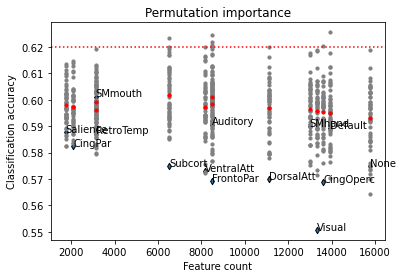

In [12]:
fig, ax = plt.subplots()
plt.scatter(num_feat,net_scores, 20, marker='d', edgecolor='black')
for i, txt in enumerate(list(netlist)):
        ax.annotate(txt, (num_feat[i], net_scores[i]))   
        
plt.title("Permutation importance")
ax.set_ylabel('Classification accuracy')
ax.set_xlabel('Feature count')

ax.axhline(y=.62, color = 'r', linestyle = ':')

for i in range(14):
    ax.scatter(np.repeat(num_feat[i],50), null_scores[i], 10, color = 'grey')

ax.scatter(num_feat, np.mean(null_scores, 1), 10, color = 'r')
